In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import PyCrystalField as cef
from copy import deepcopy
import pylib.plotformat as pf

import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize

 *******************************************************
 *                PyCrystalField 2.3.11               *
 *  Please cite  J. Appl. Cryst. (2021). 54, 356-362   * 
 *    <https://doi.org/10.1107/S160057672001554X>      *
 *******************************************************



# Refit KCeO$_2$ using rereduced data

This time use the phonon energy from the fit

In [3]:
# CEF Hamiltonian from  https://journals.aps.org/prb/abstract/10.1103/PhysRevB.104.094421
initialBs = {'B20':3.7740, 'B40':-0.2120, 'B43':6.3963}
Ce = cef.CFLevels.Bdict('Ce3+', initialBs)

Ce.printEigenvectors()


 Eigenvalues 	 Eigenvectors
		-------------------------------------------------
0.00000 	|  [ 0.     0.    -0.881  0.     0.     0.473]  |
0.00000 	|  [-0.473  0.     0.    -0.881  0.     0.   ]  |
118.77625 	|  [ 0. -1.  0.  0.  0.  0.]  |
118.77625 	|  [ 0.  0.  0.  0. -1.  0.]  |
145.71651 	|  [-0.881  0.     0.     0.473  0.     0.   ]  |
145.71651 	|  [ 0.     0.    -0.473  0.     0.    -0.881]  |
		-------------------------------------------------



[  4.46222699 118.57939111   6.61691263   1.22687803 146.03542867
   7.20424296   2.37159852 170.18755529   6.62442039   3.32715761]
alpha =  6.815191991568306
gamma = 3.327157607265656


<ErrorbarContainer object of 3 artists>

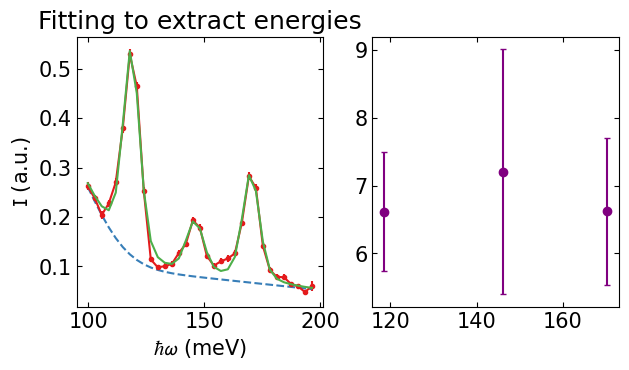

In [ ]:
## Import data
datafile = 'KCO_ARCS/rereduced_KCeO2_ARCS.txt'
data = np.genfromtxt(datafile, unpack=True)
data[1:] *= 1e4
datafit = data[:,33:]

#######################
from scipy.special import wofz
from scipy.optimize import curve_fit, minimize

def gaus(x, a, x0, sig):
    return a/(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - x0)/sig, 2.)/2.)

def voigt(x, x0, alpha, gamma):
    """ Return the Voigt line shape at x with Lorentzian component FWHM gamma
    and Gaussian component FWHM alpha."""
    sigma = (0.5*alpha) / np.sqrt(2 * np.log(2))
    return np.real(wofz(((x-x0) + 1j*(0.5*gamma))/sigma/np.sqrt(2))) / sigma\
                                                        /np.sqrt(2*np.pi)

#######################

def background(x):
    return gaus(x, 11, 83, 17) - 0.0005*x + 0.152


def gausfitfun(x, a0,x0,w0, a1,x1,w1, a2,x2,w2, lw):
    '''five Voigt functions for the five peaks. Each has its own Gaussian width,
    but all have the same Lorentzian width "lw".'''
    return a0*voigt(x,x0,w0, lw) +\
           a1*voigt(x,x1,w1, lw) +\
           a2*voigt(x,x2,w2, lw) + background(x)

# Make a guess at the starting parameters:
p0 = [5.6,118.8,6,  2,146.2,8,  2.5,170.5,6, 1]

# Plot results
f, ax = plt.subplots(1,2, figsize=(7,3.5))
ax[0].errorbar(datafit[0], datafit[1], datafit[2], marker='.')
# ax[0].plot(data[0], gausfitfun(data[0], *p0), zorder=10)
ax[0].plot(datafit[0], background(datafit[0]), ls='--')
ax[0].set_xlabel('$\\hbar \\omega$ (meV)')
ax[0].set_ylabel('$\\rm I$ (a.u.)')
ax[0].set_title('Fitting to extract energies')

poptinitial, pcovinitial = curve_fit(gausfitfun, datafit[0][3:], datafit[1][3:], p0=p0)
uncinitial = np.sqrt(np.diag(pcovinitial))
print(poptinitial)

ax[0].plot(datafit[0], gausfitfun(datafit[0], *poptinitial), zorder=10)

ObservedEnergies, DOE = [poptinitial[3*i+1] for i in range(0,3)],  [uncinitial[3*i+1] for i in range(0,3)], 
ObservedWidths, DOW =  [poptinitial[3*i+2] for i in range(0,3)], [uncinitial[3*i+2] for i in range(0,3)]
## Set values for fit
alpha = np.mean(ObservedWidths)
gamma = poptinitial[-1]

print('alpha = ', np.mean(ObservedWidths))
print('gamma =', poptinitial[-1])

ax[1].errorbar(ObservedEnergies, ObservedWidths, xerr = DOE, yerr = DOW, capsize=2, marker='o', 
               ls='none', color='purple', label='Obs. peaks')

## Set up fit function with intensities

In [5]:
## Define phonon distortion operator: B20
ion, n,m = 'Ce3+', 2,1
ionJ = cef.Jion[ion][-1]
PhononOO = cef.StevensOp(ionJ,n,m) #* 3.5
PhononHW = 35

In [6]:
a_z = np.array([[1,0],[0,-1]])/2
a_mu = np.array([[0,1],[0,0]])
a_mu_dag = np.array([[0,0],[1,0]])
Hphon_small = np.dot(a_mu_dag, a_mu) 

III = np.identity(2)


def constructHamiltonian(CEFobj, phononHW, phononOO):
    H_cef = np.kron(CEFobj.H, III)
    H_phon1 = np.kron(np.identity(len(Ce.H)),  Hphon_small)
    H_int = np.kron(phononOO,  a_mu_dag + a_mu)
    H_phons = H_phon1*phononHW
    return H_cef + H_phons + H_int

####### Define CEF operators
CEFJx = np.kron(cef.Operator.Jx(Ce.J).O.real, III)
CEFJy = np.kron(cef.Operator.Jy(Ce.J).O.real, III)
CEFJz = np.kron(cef.Operator.Jz(Ce.J).O.real, III)

## Define phonon operators
PHOJp1 = np.kron(np.identity(len(Ce.H)), a_mu)
PHOJm1 = np.kron(np.identity(len(Ce.H)), a_mu_dag)

##################################

def CEFtransition(ket1, ket2):
    ax = np.dot(ket1, np.dot(CEFJx, ket2))**2
    ay = np.dot(ket1, np.dot(CEFJy, ket2))**2
    az = np.dot(ket1, np.dot(CEFJz, ket2))**2
    return np.real(ax + ay + az)

def PHOtransition(ket1, ket2):
    ap1 = np.dot(ket1, np.dot(PHOJp1, ket2))**2
    am1 = np.dot(ket1, np.dot(PHOJm1, ket2))**2
    return np.real(ap1 + am1)

###################


def normalizedNeutronSpectrum(eigenvalues, eigenkets, Earray, Temp, alpha, gamma = 0):
    intensity = np.zeros(len(Earray))
    # for population factor weights
    beta = 1/(8.61733e-2*Temp)  # Boltzmann constant is in meV/K
    Z = sum([np.exp(-beta*en) for en in eigenvalues])
    for i, ket_i in enumerate(eigenkets):
        # compute population factor
        pn = np.exp(-beta *eigenvalues[i])/Z
        if pn > 1e-3:  #only compute for transitions with enough weight
            for j, ket_j in enumerate(eigenkets):
                # compute amplitude
                mJn = CEFtransition(ket_i,ket_j)
                deltaE = eigenvalues[j] - eigenvalues[i]
                intensity += ((pn * mJn * voigt(x=Earray, x0=deltaE, alpha=alpha, 
                                                    gamma=gamma)).real).astype('float64')
    return intensity

##### 
def err_global_0(fitparams):
    """Global error function used for fitting"""
    coeff, prefactor, phonE = fitparams[:-1], fitparams[-2], fitparams[-1]

    # define new Hamiltonian
    CFLevelsObject.newCoeff(coeff)
    HH = constructHamiltonian(CFLevelsObject, phonE, PhononOO* 3.5)
    Ev1, Eve1 = np.linalg.eigh(HH)
    Eval1 = Ev1 - np.min(Ev1)
    Evec1 = Eve1.T


    # Compute error in eigenvalue
    erro=np.nansum((np.unique(np.around(Eval1,4))[2:-1] - ObservedEnergies)**2)*0.005
    # Note I played around with the factor 30 until I got the lower final error
    
    # Compute error in neutron spectrum
    erro += np.sum((((prefactor*normalizedNeutronSpectrum(Eval1, Evec1, Earray=datafit[0], Temp = 5, 
                   alpha= alpha, gamma=gamma ) + background(datafit[0]) - datafit[1]))/(datafit[2]))**2)
    return erro

10106.971073564811


<ErrorbarContainer object of 3 artists>

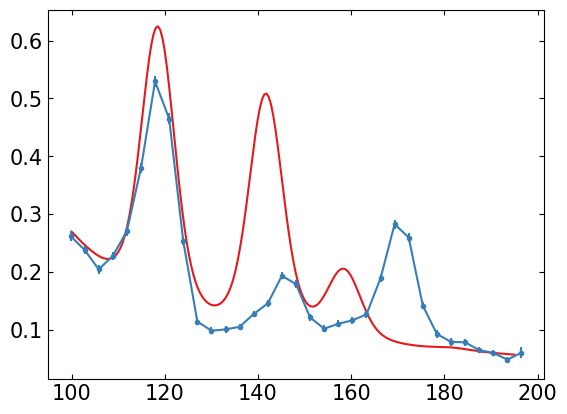

In [7]:
## Test the functions
CFLevelsObject = cef.CFLevels.Bdict('Ce3+', initialBs)

HH0 = constructHamiltonian(Ce, PhononHW, PhononOO* 3.5)
Ev0, Eve0 = np.linalg.eigh(HH0)
Eval0 = Ev0 - np.min(Ev0)
Evec0 = Eve0.T

hbaromega = np.linspace(100,195,201)
NeutronII0 = 3*normalizedNeutronSpectrum(Eval0, Evec0, Earray=hbaromega, Temp=5, 
                                       alpha=alpha, gamma=gamma)
x20 = err_global_0([3.7740, -0.2120, 6.3963, 3, 35])
print(x20)

plt.figure()
plt.plot(hbaromega, NeutronII0 + background(hbaromega))
plt.errorbar(datafit[0], datafit[1], datafit[2], marker='.')

In [8]:
### Fit
CFLevelsObject = cef.CFLevels.Bdict('Ce3+', initialBs)

res1 = minimize(err_global_0, x0=[3.7740, -0.2120, 6.3963, 3, 35], method='Nelder-Mead')

print(res1.x)
print(res1.fun)

[ 6.19847292 -0.19959103  5.90102358  2.39157297 31.94027953]
399.1513850268539


399.1513850268539


<ErrorbarContainer object of 3 artists>

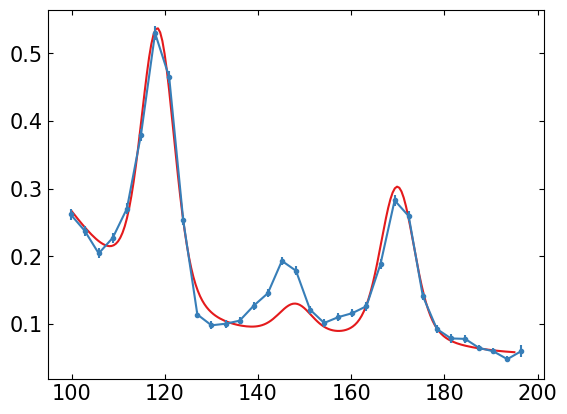

In [9]:
CeFit = cef.CFLevels.Bdict('Ce3+', initialBs)
CeFit.newCoeff(res1.x[:3])

HH1 = constructHamiltonian(CeFit, res1.x[-1], PhononOO* 3.5)
Ev0, Eve0 = np.linalg.eigh(HH1)
Eval0 = Ev0 - np.min(Ev0)
Evec0 = Eve0.T

hbaromega = np.linspace(100,195,201)
NeutronII0 = res1.x[-2]*normalizedNeutronSpectrum(Eval0, Evec0, Earray=hbaromega, Temp=5, 
                                       alpha=alpha, gamma=gamma)
x20 = err_global_0(res1.x)
print(x20)

plt.figure()
plt.plot(hbaromega, NeutronII0 + background(hbaromega))
plt.errorbar(datafit[0], datafit[1], datafit[2], marker='.')

## Try letting the coupling refine, but fix the phonon energy

In [10]:
PhononHW_fix = 36.11033
def err_global_3(fitparams):
    """Global error function used for fitting"""
    coeff, prefactor, phonstrength = fitparams[:-1], fitparams[-2], fitparams[-1]

    # define new Hamiltonian
    CFLevelsObject.newCoeff(coeff)
    HH = constructHamiltonian(CFLevelsObject, PhononHW_fix, PhononOO*phonstrength)
    Ev1, Eve1 = np.linalg.eigh(HH)
    Eval1 = Ev1 - np.min(Ev1)
    Evec1 = Eve1.T


    # Compute error in eigenvalue
    erro=np.nansum((np.unique(np.around(Eval1,4))[2:-1] - ObservedEnergies)**2)*0.01
    # Note I played around with the factor 30 until I got the lower final error
    
    # Compute error in neutron spectrum
    erro += np.sum((((prefactor*normalizedNeutronSpectrum(Eval1, Evec1, Earray=datafit[0], Temp = 5, 
                   alpha= alpha, gamma=gamma ) + background(datafit[0]) - datafit[1]))/(datafit[2]))**2)
    return erro


###########################################

### Fit
CFLevelsObject = cef.CFLevels.Bdict('Ce3+', initialBs)

res1 = minimize(err_global_3, x0=[6.46026, -0.20334,  5.6834, 2.1788, 5.05], method='Powell')
print(res1.x)
print(res1.fun)

[ 5.53559206 -0.20137833  6.14708351  2.41463404  5.23554302]
233.68462803880155


4316.972651566573


Text(0.5, 0, '$\\hbar \\omega$ (meV)')

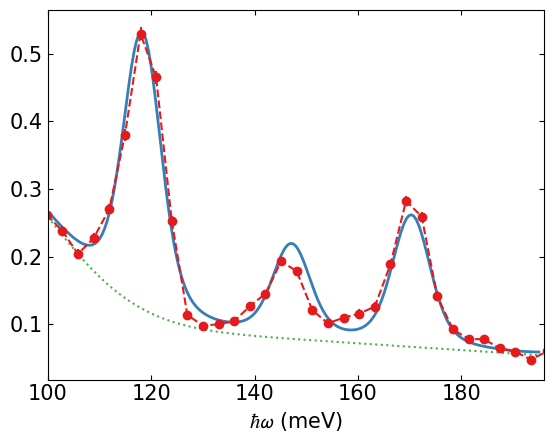

In [11]:
CeFit = cef.CFLevels.Bdict('Ce3+', initialBs)
CeFit.newCoeff(res1.x[:3])

HH1 = constructHamiltonian(CeFit, PhononHW_fix, PhononOO*res1.x[-1])
Ev0, Eve0 = np.linalg.eigh(HH1)
Eval0 = Ev0 - np.min(Ev0)
Evec0 = Eve0.T

hbaromega = np.linspace(100,195,201)
NeutronII1 = res1.x[-2]*normalizedNeutronSpectrum(Eval0, Evec0, Earray=hbaromega, Temp=5, 
                                       alpha=alpha, gamma=gamma)
x20 = err_global_0(res1.x)
print(x20)

plt.figure()
plt.errorbar(datafit[0], datafit[1], datafit[2], marker='o', ls='--')
plt.plot(hbaromega, NeutronII1 + background(hbaromega), lw=2)
plt.plot(hbaromega, background(hbaromega), ls=':')
plt.xlim(100,196)
plt.xlabel('$\\hbar \\omega$ (meV)')

In [12]:
CeFit.printEigenvectors()


 Eigenvalues 	 Eigenvectors
		-------------------------------------------------
0.00000 	|  [-0.393  0.     0.    -0.92   0.     0.   ]  |
0.00000 	|  [ 0.     0.    -0.92   0.     0.     0.393]  |
118.52009 	|  [ 0. -1.  0.  0.  0.  0.]  |
118.52009 	|  [ 0.  0.  0.  0. -1.  0.]  |
161.50943 	|  [ 0.     0.    -0.393  0.     0.    -0.92 ]  |
161.50943 	|  [-0.92   0.     0.     0.393  0.     0.   ]  |
		-------------------------------------------------



## Final fit: fit everything!

In [ ]:
def constructHamiltonianZ(CEFobj, phononHW, phononOO, zeeman=1e-8):
    H_cef = np.kron(CEFobj.H, III)
    H_phon1 = np.kron(np.identity(len(Ce.H)),  Hphon_small)
    H_int = np.kron(phononOO,  a_mu_dag + a_mu)
    H_phons = H_phon1*phononHW
    H_zeeman = CEFJz*zeeman
    return H_cef + H_phons + H_int + H_zeeman

npts = len(datafit[1]) - 6
def err_global_4(fitparams):
    """Global error function used for fitting"""
    coeff, prefactor, phonhw, phonstrength = fitparams[:-1], fitparams[-3], fitparams[-2], fitparams[-1]

    # define new Hamiltonian
    CFLevelsObject.newCoeff(coeff)
    HH = constructHamiltonianZ(CFLevelsObject, phonhw, PhononOO*phonstrength)
    Ev1, Eve1 = np.linalg.eigh(HH)
    Eval1 = Ev1 - np.min(Ev1)
    Evec1 = Eve1.T


    # Compute error in eigenvalue
    # erro=np.nansum((np.unique(np.around(Eval1,4))[2:-1] - ObservedEnergies)**2)*0.001
    # Note I played around with the factor 30 until I got the lower final error
    
    # Compute error in neutron spectrum
    erro = np.sum((((prefactor*normalizedNeutronSpectrum(Eval1, Evec1, Earray=datafit[0], Temp = 5, 
                   alpha= alpha, gamma=gamma ) + background(datafit[0]) - datafit[1]))/(datafit[2]))**2)
    return erro/npts


###########################################

### Fit
CFLevelsObject = cef.CFLevels.Bdict('Ce3+', initialBs)

res1 = minimize(err_global_4, x0=[ 5.71175, -0.20433, 6.08891, 2.28730, 36, 5.49395], method='Powell')
print(res1.x)
print(res1.fun)

finalfitx = deepcopy(res1.x)

[ 5.58144838 -0.2004733   6.20595493  2.41739827 33.24650772  5.11527407]
4.5899635433164825


4.5899635433164825


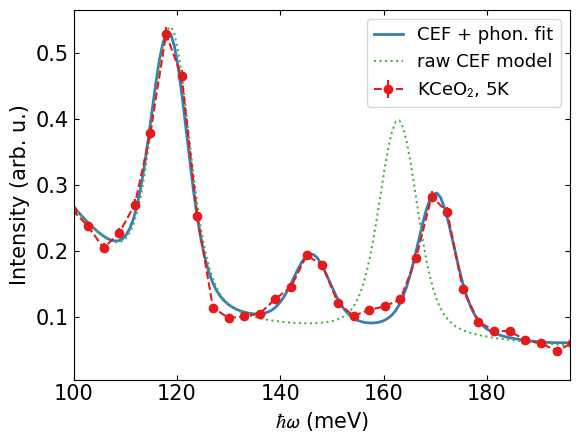

In [23]:
CeFit = cef.CFLevels.Bdict('Ce3+', initialBs)
CeFit.newCoeff(res1.x[:3])

HH1 = constructHamiltonianZ(CeFit, res1.x[-2], PhononOO*res1.x[-1])
HH0 = constructHamiltonianZ(CeFit, res1.x[-2], PhononOO*res1.x[-1]*0)
Ev0, Eve0 = np.linalg.eigh(HH0)
Eval0 = Ev0 - np.min(Ev0)
Evec0 = Eve0.T
Ev1, Eve1 = np.linalg.eigh(HH1)
Eval1 = Ev1 - np.min(Ev1)
Evec1 = Eve1.T

hbaromega = np.linspace(100,245,201)
NeutronII1 = res1.x[-3]*normalizedNeutronSpectrum(Eval1, Evec1, Earray=hbaromega, Temp=5, 
                                       alpha=alpha, gamma=gamma)
NeutronII0 = res1.x[-3]*normalizedNeutronSpectrum(Eval0, Evec0, Earray=hbaromega, Temp=5, 
                                       alpha=alpha, gamma=gamma)
x20 = err_global_4(res1.x)
print(x20)

f,ax = plt.subplots()
plt.errorbar(datafit[0], datafit[1], datafit[2], marker='o', ls='--', label='KCeO$_2$, 5K')
ax.plot(hbaromega, NeutronII1 + background(hbaromega), lw=2, label='CEF + phon. fit')
ax.plot(hbaromega, NeutronII0 + background(hbaromega), ls=':', label='raw CEF model')
# ax.plot(hbaromega, background(hbaromega), ls=':', color='grey')
ax.set_xlim(100,196)
ax.set_xlabel('$\\hbar \\omega$ (meV)')
ax.set_ylabel("Intensity (arb. u.)")
ax.legend(handlelength=1.6, fontsize=13)

plt.savefig('writeup/KCeO2_refit.pdf', bbox_inches='tight',
            pad_inches = 0.03)

In [24]:
CeFit.printEigenvectors()


 Eigenvalues 	 Eigenvectors
		-------------------------------------------------
0.00000 	|  [ 0.     0.    -0.919  0.     0.     0.393]  |
0.00000 	|  [-0.393  0.     0.    -0.919  0.     0.   ]  |
118.80826 	|  [ 0. -1.  0.  0.  0.  0.]  |
118.80826 	|  [ 0.  0.  0.  0. -1.  0.]  |
162.84963 	|  [ 0.     0.    -0.393  0.     0.    -0.919]  |
162.84963 	|  [-0.919  0.     0.     0.393  0.     0.   ]  |
		-------------------------------------------------



## Add uncertainty

In [ ]:
def chisquared(fitparams):
    return err_global_4(fitparams)

# bestPars = initialres.x
bestPars = finalfitx
bestChiSq = chisquared(bestPars)

lowChisqP = []
lowChisqChi = []

#### 

for i in range(len(finalfitx)):
    # Loop through 
    baseB20 = bestPars[i]
    newpars = deepcopy(bestPars)
    jj = 1
    step = 0.005
    while True:
        testB20 = baseB20*jj
        def truncatedChisquared(pars):
            return chisquared(np.hstack((pars[:i], testB20, pars[i:])))
        res = minimize(truncatedChisquared, x0 = np.hstack((newpars[:i], newpars[i+1:])), 
                        method='Nelder-Mead')

        print(i, jj, res.fun)
        newpars = np.hstack((res.x[:i], testB20, res.x[i:]))

        if res.fun > (bestChiSq+1):
            break
        else:
            lowChisqP.append(newpars)
            lowChisqChi.append(res.fun)
            jj += step
        if np.around(np.abs(jj),2) == 5: step *= 2
        elif np.around(np.abs(jj),2) in [20,50]: step *= 5
        elif np.abs(jj) > 200: break


    step = 0.005
    jj = 1-step
    newpars = deepcopy(bestPars)
    ## Do again, counting the other way.
    while True:
        testB20 = baseB20*jj
        def truncatedChisquared(pars):
            return chisquared(np.hstack((pars[:i], testB20, pars[i:])))
        res = minimize(truncatedChisquared, x0 = np.hstack((newpars[:i], newpars[i+1:])), 
                        method='Nelder-Mead')
        print(i, jj, res.fun)
        newpars = np.hstack((res.x[:i], testB20, res.x[i:]))
        if res.fun > (bestChiSq+1):
            break
        else:
            lowChisqP.append(newpars)
            lowChisqChi.append(res.fun)
            jj -= step
        if np.around(np.abs(jj),2) == 5: step *= 2
        elif np.around(np.abs(jj),2) in [20,50]: step *= 5
        elif np.abs(jj) > 200: break

############# Save results

lowChisqP = np.array(lowChisqP)

savedir = 'KCO_ARCS/fitresults/KCeO2_'
np.save(savedir+'BestFit_uncertainty_P.dat', lowChisqP)
np.save(savedir+'BestFit_uncertainty_Chi.dat',lowChisqChi)



0 1 4.589963461038561
0 1.005 4.594696866031056
0 1.0099999999999998 4.6089959917653935
0 1.0149999999999997 4.633108897698386
0 1.0199999999999996 4.6672852814907
0 1.0249999999999995 4.711776244243371
0 1.0299999999999994 4.766833938872484
0 1.0349999999999993 4.832711261342752
0 1.0399999999999991 4.909661595081318
0 1.044999999999999 4.997938325905703
0 1.049999999999999 5.097794491439464
0 1.0549999999999988 5.209482382617175
0 1.0599999999999987 5.333253063901598
0 1.0649999999999986 5.46935592530728
0 1.0699999999999985 5.618038145979434
0 0.995 4.594549611471436
0 0.99 4.608211286816175
0 0.985 4.630706806644453
0 0.98 4.661796998135995
0 0.975 4.701245422244046
0 0.97 4.748818492745779
0 0.965 4.804285628125608
0 0.96 4.867419372695942
0 0.955 4.937995518948539
0 0.95 5.015793204955332
0 0.945 5.100594989828611
0 0.94 5.192186929884581
0 0.9349999999999999 5.290358651544792
0 0.9299999999999999 5.394903367272606
0 0.9249999999999999 5.505617989448187
0 0.9199999999999999 5.622

In [39]:
lowChisqGtensor = []
lowChisqEvals = []
lowChisqEvecs = []

## Compute eigenstates
for i,P in enumerate(lowChisqP):
    CeFit2 = cef.CFLevels.Bdict('Ce3+', initialBs)
    if True:
        CeFit2.newCoeff(P[:3]) # Just insert coefficients
    else:
        newcoeff = P[:3]
        Jzz = CeFit2.opttran.Jz
        newH = np.sum([a*b for a,b in zip(CeFit2.O, newcoeff)], axis=0)
        CeFit2.diagonalize(newH + Jzz*1e-3)
    
    #if len(Yb.eigenvalues) % 2 == 0:
    try:
        lowChisqGtensor.append(CeFit2.gtensor())
    except ValueError: pass
    lowChisqEvals.append(CeFit2.eigenvalues)
    lowChisqEvecs.append(CeFit2.eigenvectors)
    
# np.save(savedir+'BestFit_uncertainty_Gtensor.dat',lowChisqGtensor)
np.save(savedir+'BestFit_uncertainty_Evals.dat', lowChisqEvals)
np.save(savedir+'BestFit_uncertainty_Evecs.dat', lowChisqEvecs)

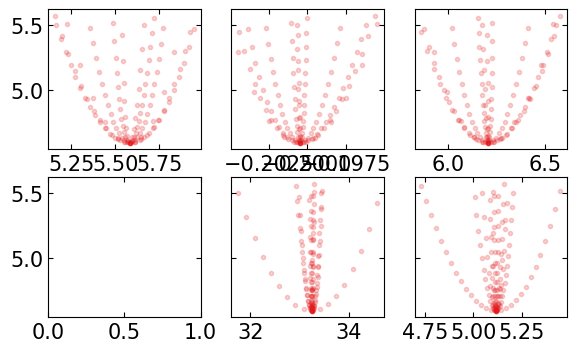

In [40]:
## Plot chi2 contour

markerprops = {'ls':'none', 'marker':'.', 'rasterized':True}

f, ax = plt.subplots(2,3,figsize=(6.7,4), sharey=True)

for i,axx in enumerate(ax.flatten()):
    jind=i
    if i !=3:
        axx.plot(lowChisqP[:,jind], lowChisqChi, alpha=0.2, **markerprops)

In [ ]:
#### Helper functions
from pylib.Uncertainty import stringUncertainty, stringUncertaintyAniso

def printLaTexEigenvectors(EV, dEV, Vec, dVec, fo, precision=4):
	'''prints eigenvectors and eigenvalues in the output that Latex can read'''

	print('\\begin{table*}\n\\caption{Eigenvectors and Eigenvalues...}',file=fo)
	print('\\begin{ruledtabular}',file=fo)
	numev = len(EV)
	print('\\begin{tabular}{c|'+'c'*numev+'}',file=fo)
	if numev % 2 == 1:
		print('E (meV) &'+' & '.join(['$|'+str(int(kk))+'\\rangle$' for kk in 
					np.arange(-(numev-1)/2,numev/2)])
			+' \\tabularnewline\n \\hline ',file=fo)
	else:
		print('E (meV) &'+
			' & '.join(['$| -\\frac{'+str(abs(kk))+'}{2}\\rangle$' if kk <0
						 else '$| \\frac{'+str(abs(kk))+'}{2}\\rangle$'
						for kk in np.arange(-(numev-1),numev,2)])
			+' \\tabularnewline\n \\hline ',file=fo)
	    
	#sortinds = EV.argsort()
	sortEVal= np.around(EV,3)
	sortEVec= np.real(Vec)
	sortdEVal= np.around(dEV,3)
	sortdEVec= np.real(dVec)
	for i in range(numev):
		print(sortEVal[i], sortdEVal[i])
		print(stringUncertainty(sortEVal[i], sortdEVal[i]))
		print(stringUncertainty(sortEVal[i], sortdEVal[i]),'&', 
			' & '.join([stringUncertainty(eevv, sortdEVec[i][j]) 
						for j,eevv in enumerate(sortEVec[i])]), '\\tabularnewline',file=fo)
	print('\\end{tabular}\\end{ruledtabular}',file=fo)
	print('\\label{flo:Eigenvectors}\n\\end{table*}',file=fo)



def printGSket(Vec, dVec):
	'''Select three largest components of ground state. Ket2 is if it is a Kramers ion'''
	ket1, ket2 = np.real(Vec)[0], np.real(Vec)[1]
	dket1, dket2 = np.real(dVec)[0],  np.real(dVec)[1]
	lenk = len(ket1)
	if lenk%2 ==0: #kramers ion
		labelrange = np.arange(-(lenk-1), lenk, 2)
		labellist = ['|{}/2 \\rangle'.format(jj) for jj in labelrange]
	else:
		labelrange = np.arange(int(-(lenk-1)/2), int((lenk+1)/2), 1)
		labellist = ['|{} \\rangle'.format(jj) for jj in labelrange]

	max3 = np.sort(np.argsort(np.abs(ket1))[-3:])
	try:
		max3b = np.sort(np.argsort(np.abs(ket2))[-3:])
		ketlist1 = [stringUncertainty(ket1[m],dket1[m])+labellist[m] for m in max3]
		ketlist2 = [stringUncertainty(ket2[m],dket2[m])+labellist[m] for m in max3b[::-1]]

		return '\\psi_0+ = '+' + '.join(ketlist1) + ' ,  ' +'\\psi_0- = '+' + '.join(ketlist2)
	except TypeError:
		ketlist1 = [stringUncertainty(ket1[m],dket1[m])+labellist[m] for m in max3]

		return '\\psi_0 = '+' + '.join(ketlist1)

In [119]:
ion = 'Ce3+'

outputfile = savedir+'ProcessedOutput.txt'
with open(outputfile, 'w') as fo:

    # ################# PLOT OUTPUT
    # f, ax = plt.subplots(1,3,figsize=(9,3), sharey=True)

    # sf = 1
    # markerprops = {'ls':'none', 'marker':'.', 'rasterized':True}

    # axes= ax.flatten()
    # for i, axx in enumerate(axes):
    # 	jind = i+1
    # 	try:
    # 		axx.plot(lowChisqP[:,jind]*sf, lowChisqChi, alpha=0.1, **markerprops)
    # 	except IndexError: pass

    # ax[0].set_ylabel('$\\chi^2_{red}$')

    ################## OUTPUT LATEX TABLE
    print('#### CEF parameters', file=fo)

    ## Output latex table
    ns = [2,4,4]
    ms = [0,0,3]

    i = 0
    rows = int(len(ns))
    for jj in range(rows):

        J = bestPars[i]
        unc = (np.max(lowChisqP[:,i]) - np.min(lowChisqP[:,i]))/2
        print(J,unc)
            
        sigdigits = int(-np.log10(unc)+1)
        if -np.log10(unc)+1 < 0:
            sigdigits = int(-np.log10(unc))
        #             sigdigits += 1
        if str(np.around(unc,sigdigits))[0] == '1':
            sigdigits += 1
            if str(np.around(unc, sigdigits)*1e10)[0] == '9':
                sigdigits -= 1
        if sigdigits > 0:
            if str(np.around(unc,sigdigits))[-1] == '1':
                sigdigits += 1
        if sigdigits <= 0:
            print('$B_{'+str(ns[i])+'}^{'+str(ms[i])+'}=$  &  $', 
                    int(np.around(J, sigdigits)), '\\pm', int(np.around(unc, sigdigits)), end = '$',
                    file=fo)
        else:
            print('$B_{'+str(ns[i])+'}^{'+str(ms[i])+'}=$  &  $', 
                np.around(J, sigdigits), '\\pm', np.around(unc, sigdigits), end = '$', file=fo)

        i += 1
        print(' \\\\', file=fo)

    #####################
    ## G tensor
    print('\n#### G-tensor', file=fo)
    try:
        optG = np.abs(lowChisqGtensor[0])
        maxG = np.max(np.abs(lowChisqGtensor), axis=0)
        minG = np.min(np.abs(lowChisqGtensor), axis=0)
        uncG = (maxG - minG)/2

        print(optG, maxG, minG)

        # for i in range(3):
        # 	print(' & '.join([stringUncertaintyAniso(optG[i,j], maxG[i,j], minG[i,j]) for j in range(3)]), 
        # 		end=' \\\\ \n', file=fo)
        for i in range(3):
            print(stringUncertaintyAniso(optG[i,i], maxG[i,i], minG[i,i]) , 
                end=' \n', file=fo)
    except IndexError: pass



    ######################## PRINT LATEX TABLE OF BEST FIT

    print('\n#### best fit Eigenvalues', file=fo)

    ## Eigenvalues and eigenvectors
    optVal = lowChisqEvals[0]
    maxVal = np.max(np.abs(lowChisqEvals), axis=0)
    minVal = np.min(np.abs(lowChisqEvals), axis=0)
    uncVal = (maxVal - minVal)/2

    ## Because of the Kramers doublet, the eigenvalue doesn't always come out the same way. 
    ## We'll have to loop through and sort the eigenvectors...
    JZ = cef.Operator.Jz(cef.Jion[ion][-1])
    sortedLowChisqEvecs = deepcopy(lowChisqEvecs)
    for i in range(len(lowChisqEvals)):
        for j in range(0,len(lowChisqEvals[i])-1,2):
            if (np.abs(lowChisqEvals[i][j] - lowChisqEvals[i][j+1])) < 1e-4:
                ev1 = lowChisqEvecs[i][j]
                ev2 = lowChisqEvecs[i][j+1]
                Jexp1 = np.real(np.dot(ev1**2,np.dot(JZ.O,ev1)))
                Jexp2 = np.real(np.dot(ev2**2,np.dot(JZ.O,ev2)))
                if Jexp1 < Jexp2:
                    sortedLowChisqEvecs[i][j]   = lowChisqEvecs[i][j+1]
                    sortedLowChisqEvecs[i][j+1] = lowChisqEvecs[i][j]
                else:
                    # if j == 0:
                    #     print('not flipped', i, np.around([Jexp1,Jexp2], 3))
                    sortedLowChisqEvecs[i][j]  = lowChisqEvecs[i][j]
                    sortedLowChisqEvecs[i][j+1]= lowChisqEvecs[i][j+1]

    optVec = sortedLowChisqEvecs[0]

    maxVec = np.max(np.abs(sortedLowChisqEvecs), axis=0)
    minVec = np.min(np.abs(sortedLowChisqEvecs), axis=0)
    # uncVec = (maxVec - minVec)/2  
    uncVec = (np.abs(maxVec) - np.abs(minVec))/2

    ### Print LaTex table
    printLaTexEigenvectors(optVal, uncVal, optVec, uncVec, fo)

    ## Now, print just ground state ket
    print('\n#### Ground State Ket', file=fo)
    print(printGSket(optVec, uncVec), file=fo)

    
    print('\n#### phonon energy and coupling', file=fo)
    i=4
    value = bestPars[i]
    unc = (np.max(lowChisqP[:,i]) - np.min(lowChisqP[:,i]))/2
    print('hw = ', value, '+/-', unc, file=fo)
    i=5
    value = bestPars[i]
    unc = (np.max(lowChisqP[:,i]) - np.min(lowChisqP[:,i]))/2
    print('B21 coupling = ', value, '+/-', unc, file=fo)


5.5814483830578805 0.39297608761766645
-0.2004732999839984 0.004510649249639925
6.205954927448187 0.35684240832826664
[[2.17387071 0.         0.        ]
 [0.         2.17387071 0.        ]
 [0.         0.         0.06202714]] [[2.22473638 0.         0.        ]
 [0.         2.22473638 0.        ]
 [0.         0.         0.16375847]] [[2.11147810e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.11147810e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.60008514e-04]]
0.0 0.0
0.0
0.0 0.0
0.0
118.808 0.157
118.8(2)
118.808 0.157
118.8(2)
162.849 0.882
162.8(9)
162.849 0.882
162.8(9)


In [122]:
i =40
j = 0

ev1 = lowChisqEvecs[i][j]
ev2 = lowChisqEvecs[i][j+1]
Jexp1 = np.real(np.dot(ev1**2,np.dot(JZ.O,ev1)))
Jexp2 = np.real(np.dot(ev2**2,np.dot(JZ.O,ev2)))

print(ev1)
print(ev2)
print(Jexp1)
print(Jexp2)
print(lowChisqEvals[i][j:j+2])

print(sortedLowChisqEvecs[i])

[-0.39561369+0.j  0.        +0.j  0.        +0.j -0.91841701+0.j
  0.        +0.j  0.        +0.j]
[ 0.        +0.j  0.        +0.j -0.91841701+0.j  0.        +0.j
  0.        +0.j  0.39561369+0.j]
-0.2325437534596773
0.5421316328188692
[0. 0.]
[[ 0.        +0.j  0.        +0.j -0.91841701+0.j  0.        +0.j
   0.        +0.j  0.39561369+0.j]
 [-0.39561369+0.j  0.        +0.j  0.        +0.j -0.91841701+0.j
   0.        +0.j  0.        +0.j]
 [ 0.        +0.j -1.        +0.j  0.        +0.j  0.        +0.j
   0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  -1.        +0.j  0.        +0.j]
 [-0.91841701+0.j  0.        +0.j  0.        +0.j  0.39561369+0.j
   0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j -0.39561369+0.j  0.        +0.j
   0.        +0.j -0.91841701+0.j]]


In [117]:
i =50
j = 0

ev1 = lowChisqEvecs[i][j]
ev2 = lowChisqEvecs[i][j+1]
Jexp1 = np.real(np.dot(ev1**2,np.dot(JZ.O,ev1)))
Jexp2 = np.real(np.dot(ev2**2,np.dot(JZ.O,ev2)))

print(ev1)
print(ev2)
print(Jexp1)
print(Jexp2)

[ 0.        +0.j  0.        +0.j -0.90734695+0.j  0.        +0.j
  0.        +0.j  0.42038259+0.j]
[-0.42038259+0.j  0.        +0.j  0.        +0.j -0.90734695+0.j
  0.        +0.j  0.        +0.j]
0.5592262308434173
-0.18777298503494816
